In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [27]:
db=tf.keras.preprocessing.image_dataset_from_directory('dataset',
                                                     image_size=(318,218),
                                                     batch_size=32,
                                                     shuffle=True,
                                                     )

Found 3833 files belonging to 2 classes.


In [28]:
class_names=db.class_names

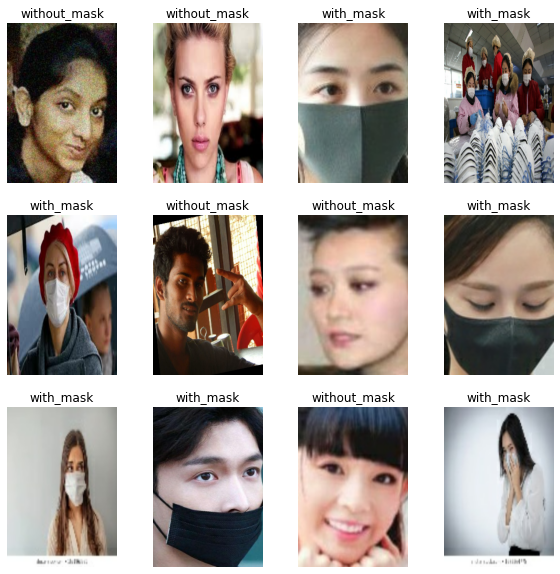

In [29]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in db.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(db.class_names[labels_batch[i]])
        plt.axis("off")

In [30]:
len(db)

120

In [31]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [32]:
train_db,val_db,test_db=get_dataset_partitions_tf(db)

In [33]:
len(train_db)

96

In [34]:
len(test_db)

12

In [35]:
len(val_db)

12

In [36]:
train_db = train_db.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_db = val_db.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_db = test_db.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(318,218),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [39]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [40]:
train_db= train_db.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
input_shape = (32,318,218,3)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 318, 218, 3)         0         
                                                                 
 sequential_5 (Sequential)   (None, 318, 218, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 316, 216, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 158, 108, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 156, 106, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 78, 53, 64)         0         
 2D)                                                  

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_db,
    batch_size=32,
    validation_data=val_db,
    verbose=1,
    epochs=25,
)

Epoch 1/25
96/96 [==============================] - 260s 3s/step - loss: 0.4277 - accuracy: 0.8062 - val_loss: 0.2772 - val_accuracy: 0.8984
Epoch 2/25
96/96 [==============================] - 247s 3s/step - loss: 0.3018 - accuracy: 0.8825 - val_loss: 0.2626 - val_accuracy: 0.8854
Epoch 3/25
96/96 [==============================] - 243s 3s/step - loss: 0.2836 - accuracy: 0.8946 - val_loss: 0.2901 - val_accuracy: 0.8984
Epoch 4/25
96/96 [==============================] - 240s 2s/step - loss: 0.2727 - accuracy: 0.8953 - val_loss: 0.2186 - val_accuracy: 0.9115
Epoch 5/25
96/96 [==============================] - 227s 2s/step - loss: 0.2759 - accuracy: 0.8962 - val_loss: 0.2995 - val_accuracy: 0.8880
Epoch 6/25
96/96 [==============================] - 227s 2s/step - loss: 0.2617 - accuracy: 0.9024 - val_loss: 0.3645 - val_accuracy: 0.8411
Epoch 7/25
96/96 [==============================] - 231s 2s/step - loss: 0.2686 - accuracy: 0.8943 - val_loss: 0.3570 - val_accuracy: 0.8594
Epoch 8/25
96

In [45]:
scores = model.evaluate(test_db)
scores

12/12 [==============================] - 9s 265ms/step - loss: 0.1505 - accuracy: 0.9193


[0.15054325759410858, 0.9192708134651184]

first image to predict
actual label: without_mask
1/1 [==============================] - 0s 453ms/step
predicted label: without_mask


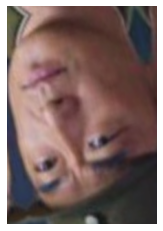

In [46]:
import numpy as np
for images_batch, labels_batch in train_db.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [47]:
import os
model.save(f"models/1")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets
